# mini5. 중간 프로젝트
## 5팀 : 심전근 뇌졸증 진단 프로그램
1. Heart Failure Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction   
데이터 이름 : 'Healthcare-Stroke.csv'   
데이터 포맷 : (row, col)   
메타데이터 :   
    - id : 고유 식별자
    - gender : 환자의 성별
    - age : 환자의 연령
    - hypertension : 환자가 고혈압이 아닌 경우 0, 고혈압인 경우 1
    - heart_parament : 환자가 심장 질환이 없는 경우 0, 환자가 심장 질환이 있는 경우 1
    - ever_married : 결혼한 적이 있는가 "아니오" 또는 "예"
    - work_type : "Children", "Govt_jov", "Never_worked", "Private" 또는 "Self-employed"
    - Residence_type : "Rural" or "Urban”
    - avg_glucose_level : 혈중 평균 포도당 수준
    - bmi : 체질량지수
    - smoking_status : "formerly smoked", "never smoked", "smokes" or "Unknown"
    - stroke : 뇌졸중이 있는 경우 1, 뇌졸중이 아닌 경우 0
    - 참고 : smoking_status의 Unknown은 이 환자에 대한 정보를 사용할 수 없음을 의미한다. 
   

2. Stroke Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset   
데이터 이름 : 'Healthcare-Heart.csv'   
데이터 포맷 : (row, col)   
메타데이터 :  
    - Age : 환자의 나이
    - Sex : 환자의 성별
    - ChestPainType : 흉통 유형
        TA : 일반 협심증,  ATA : 비정형 협심증,  NAP : 비혈관 통증,  ASY : 무증상
    - RestingBP : 휴면혈압[mmHg]
    - Cholesterol : 혈청 콜레스테롤 [mm/dl]
    - FastingBS : 금식혈당
        1 : 금식인 경우BS > 120 mg/dl
        0 : 그렇지 않은 경우
    - RestingECG : 심전도 결과
        정상 : 정상
        ST : ST-T파 이상(T파 반전 및/또는 ST 상승 또는 0.05mV 이상 하강)
        LVH : Estes의 기준에 의해 발생가능하거나 확실한 좌심실 비대
    - MaxHR : 달성된 최대 심박수 (60 ~ 202)
    - ExerciseAngina : 운동으로 인한 협심증 Y/N
    - Oldpeak : 이전 피크 = ST [저하 상태에서 측정된 숫자 값]
    - ST_Slope : 피크 연습 ST 세그먼트의 기울기 [위: 상향, 평탄: 하향: 하향]
    - HeartDisease : 1 심장 질환,  0 정상 

## 0. 환경설정

### 라이브러리 호출

In [71]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from imblearn.over_sampling import SMOTE

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn Module Import
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance

### 시각화 한글 폰트 설정

In [3]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'Malgun Gothic'

### 그래프 색상 그라데이션 설정

In [4]:
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,256),0).T
    ax = bars[0].axes 
    lim = ax.get_xlim()+ax.get_ylim() 
    for bar in bars:
        bar.set_facecolor("none") 
        x,y = bar.get_xy() 
        w, h = bar.get_width(), bar.get_height() 
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) 
    ax.axis(lim)

### 사용자 함수 정의

In [5]:
# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#     return [acc, pre, rec, f1]

# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
# 상관관계 히트맵 함수
def corr_plot(data, cmap, width, height, title):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr))

    plt.figure(figsize=(width, height))
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, vmin=-1, vmax=1, fmt=".2f")
    plt.title(title, fontsize=20)
    plt.show()
    

# 혼동행렬 시각화 함수
def plot_confusion_matrix(cm, class_names, figsize=(8, 8)):
    cm = cm.numpy()
    figure = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure    

## 1. 데이터 로드
### Healthcare-Stroke.csv (row, col)

In [6]:
# Data Load
def data_load(path, file):
    df = pd.read_csv(f"{path}{file}", sep=",")
    return df

path = 'data/'
file = 'Healthcare-Stroke.csv'

In [7]:
df = data_load(path, file)
print('df.shape :',df.shape)
df.head()

df.shape : (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [9]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [10]:
# data describe
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 2. 데이터 전처리 & EDA

In [11]:
# 의미없는 'ID'특성 제거
df = df[df.columns.difference(['id'])]
df.shape

(5110, 11)

### LabelEncoding

In [12]:
# LabelEncoding
cat_list = ['gender','ever_married','work_type','Residence_type','smoking_status']
for cat in cat_list:
    l_encoder = LabelEncoder()
    l_encoder.fit(df[cat])
    labels = l_encoder.transform(df[cat])
    df[cat] = labels

    print(cat,':',l_encoder.classes_)
    print(cat,'encoded :',np.unique(labels),'\n')

gender : ['Female' 'Male' 'Other']
gender encoded : [0 1 2] 

ever_married : ['No' 'Yes']
ever_married encoded : [0 1] 

work_type : ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
work_type encoded : [0 1 2 3 4] 

Residence_type : ['Rural' 'Urban']
Residence_type encoded : [0 1] 

smoking_status : ['Unknown' 'formerly smoked' 'never smoked' 'smokes']
smoking_status encoded : [0 1 2 3] 



### MissingValue Processing

In [13]:
# gender = 2로 표기되어 있는 사람은 성별을 알 수 없으므로 제거.
df[df['gender'] == 2]

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
3116,0,26.0,143.33,22.4,0,2,0,0,1,0,2


In [14]:
df.drop(index = df[df['gender'] == 2].index, inplace=True)

In [15]:
# bmi 칼럼의 nan값들을 평균값으로 대치
df['bmi'].fillna(df['bmi'].mean(), axis=0,inplace=True)

### Outlier Processing

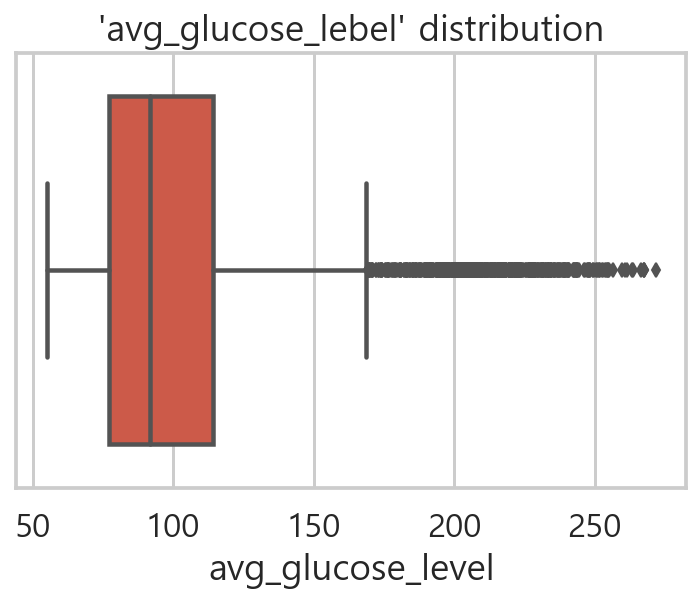

In [16]:
plt.title("'avg_glucose_lebel' distribution")
sns.boxplot(df['avg_glucose_level'])
plt.show()

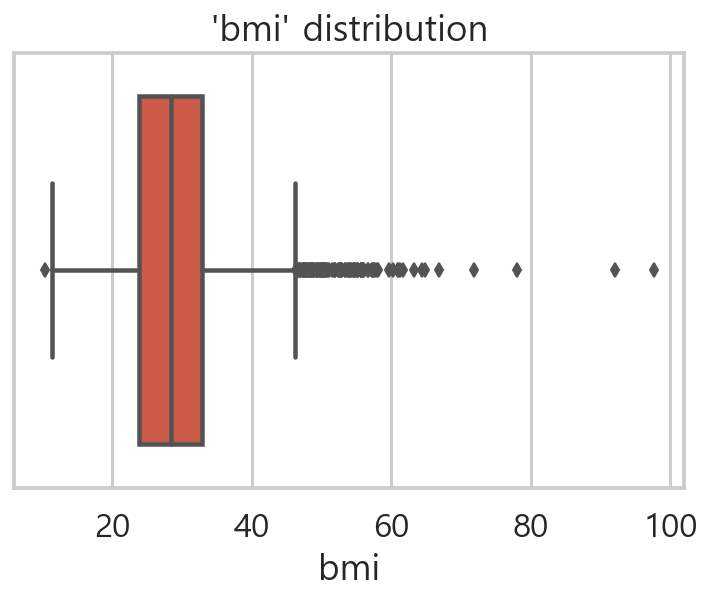

In [17]:
plt.title("'bmi' distribution")
sns.boxplot(df['bmi'])
plt.show()

In [18]:
# bmi 칼럼의 상위 4 개의 이상치에 대해 최대값으로 대치
df.loc[df['bmi'].sort_values(ascending=False)[:4].index,'bmi'] = df['bmi'].sort_values(ascending=False)[:5].values[-1]

### StandardScaler, Log Transformation

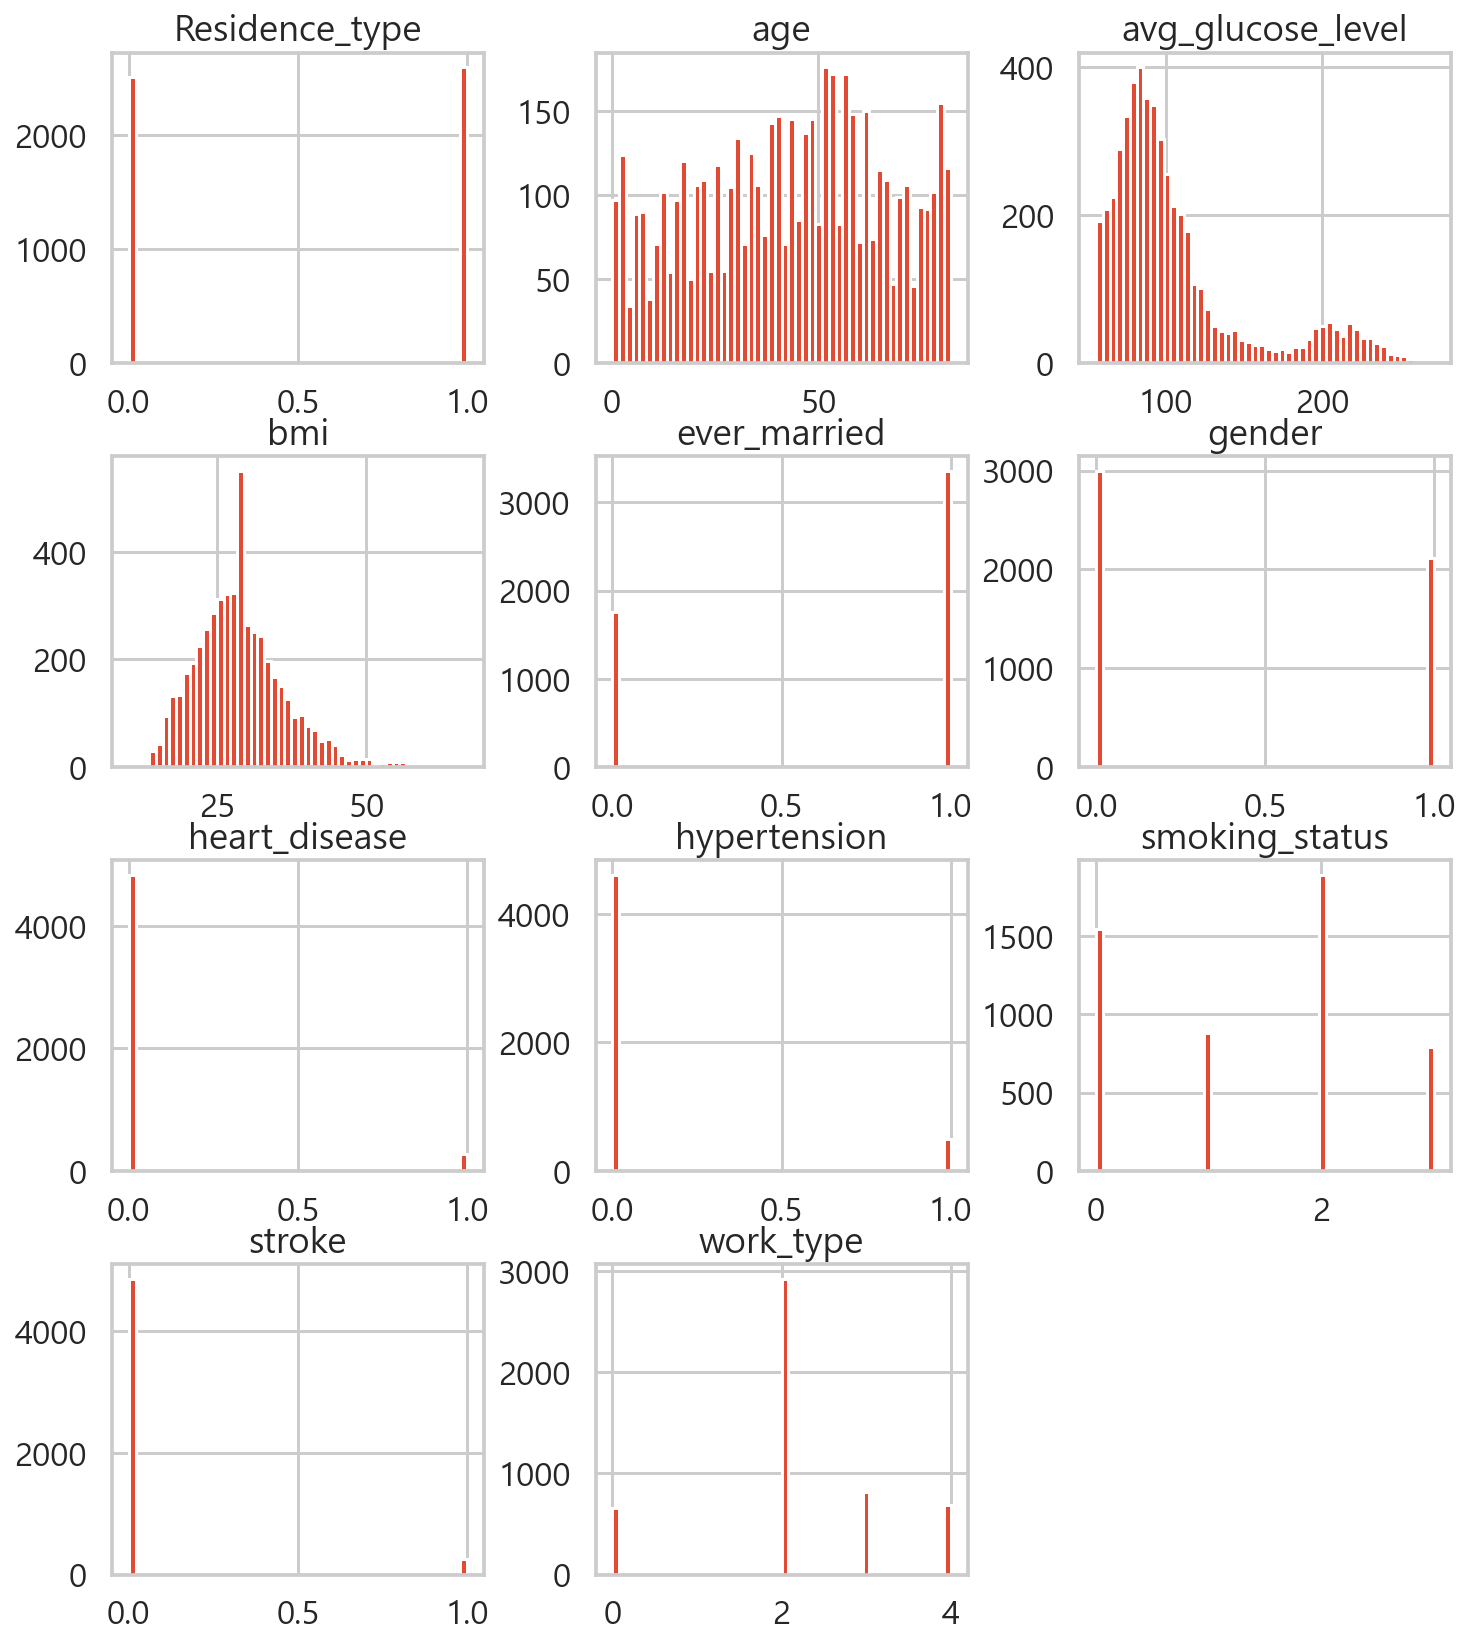

In [19]:
# Histogram
df.hist(figsize=(12,14),bins=50)
plt.show()

In [20]:
# 로그 변환 to ['bmi', 'avg_glucose_level']
df[['bmi', 'avg_glucose_level']] = np.log1p(df[['bmi', 'avg_glucose_level']])

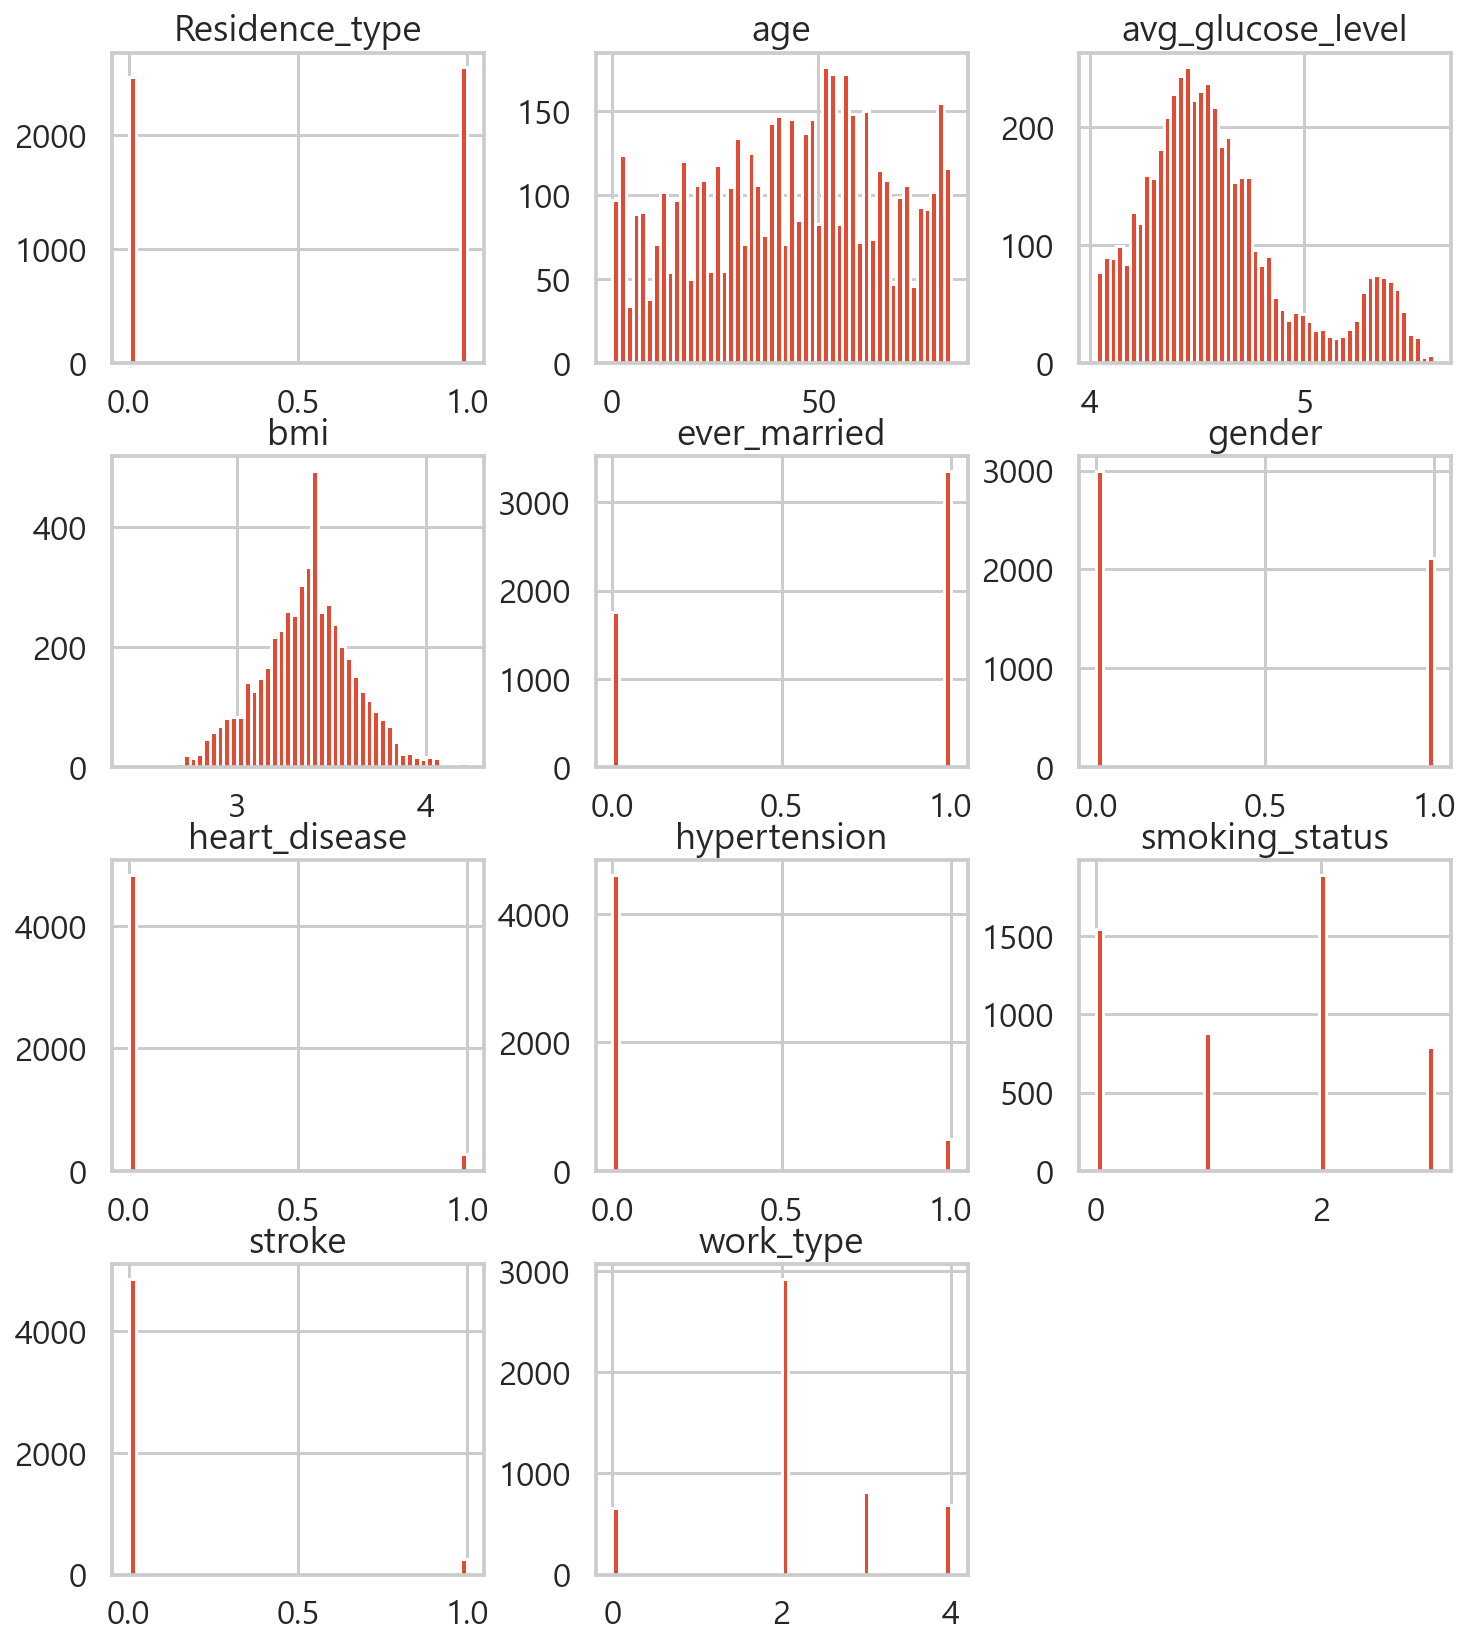

In [21]:
# Histogram
df.hist(figsize=(12,14),bins=50)
plt.show()

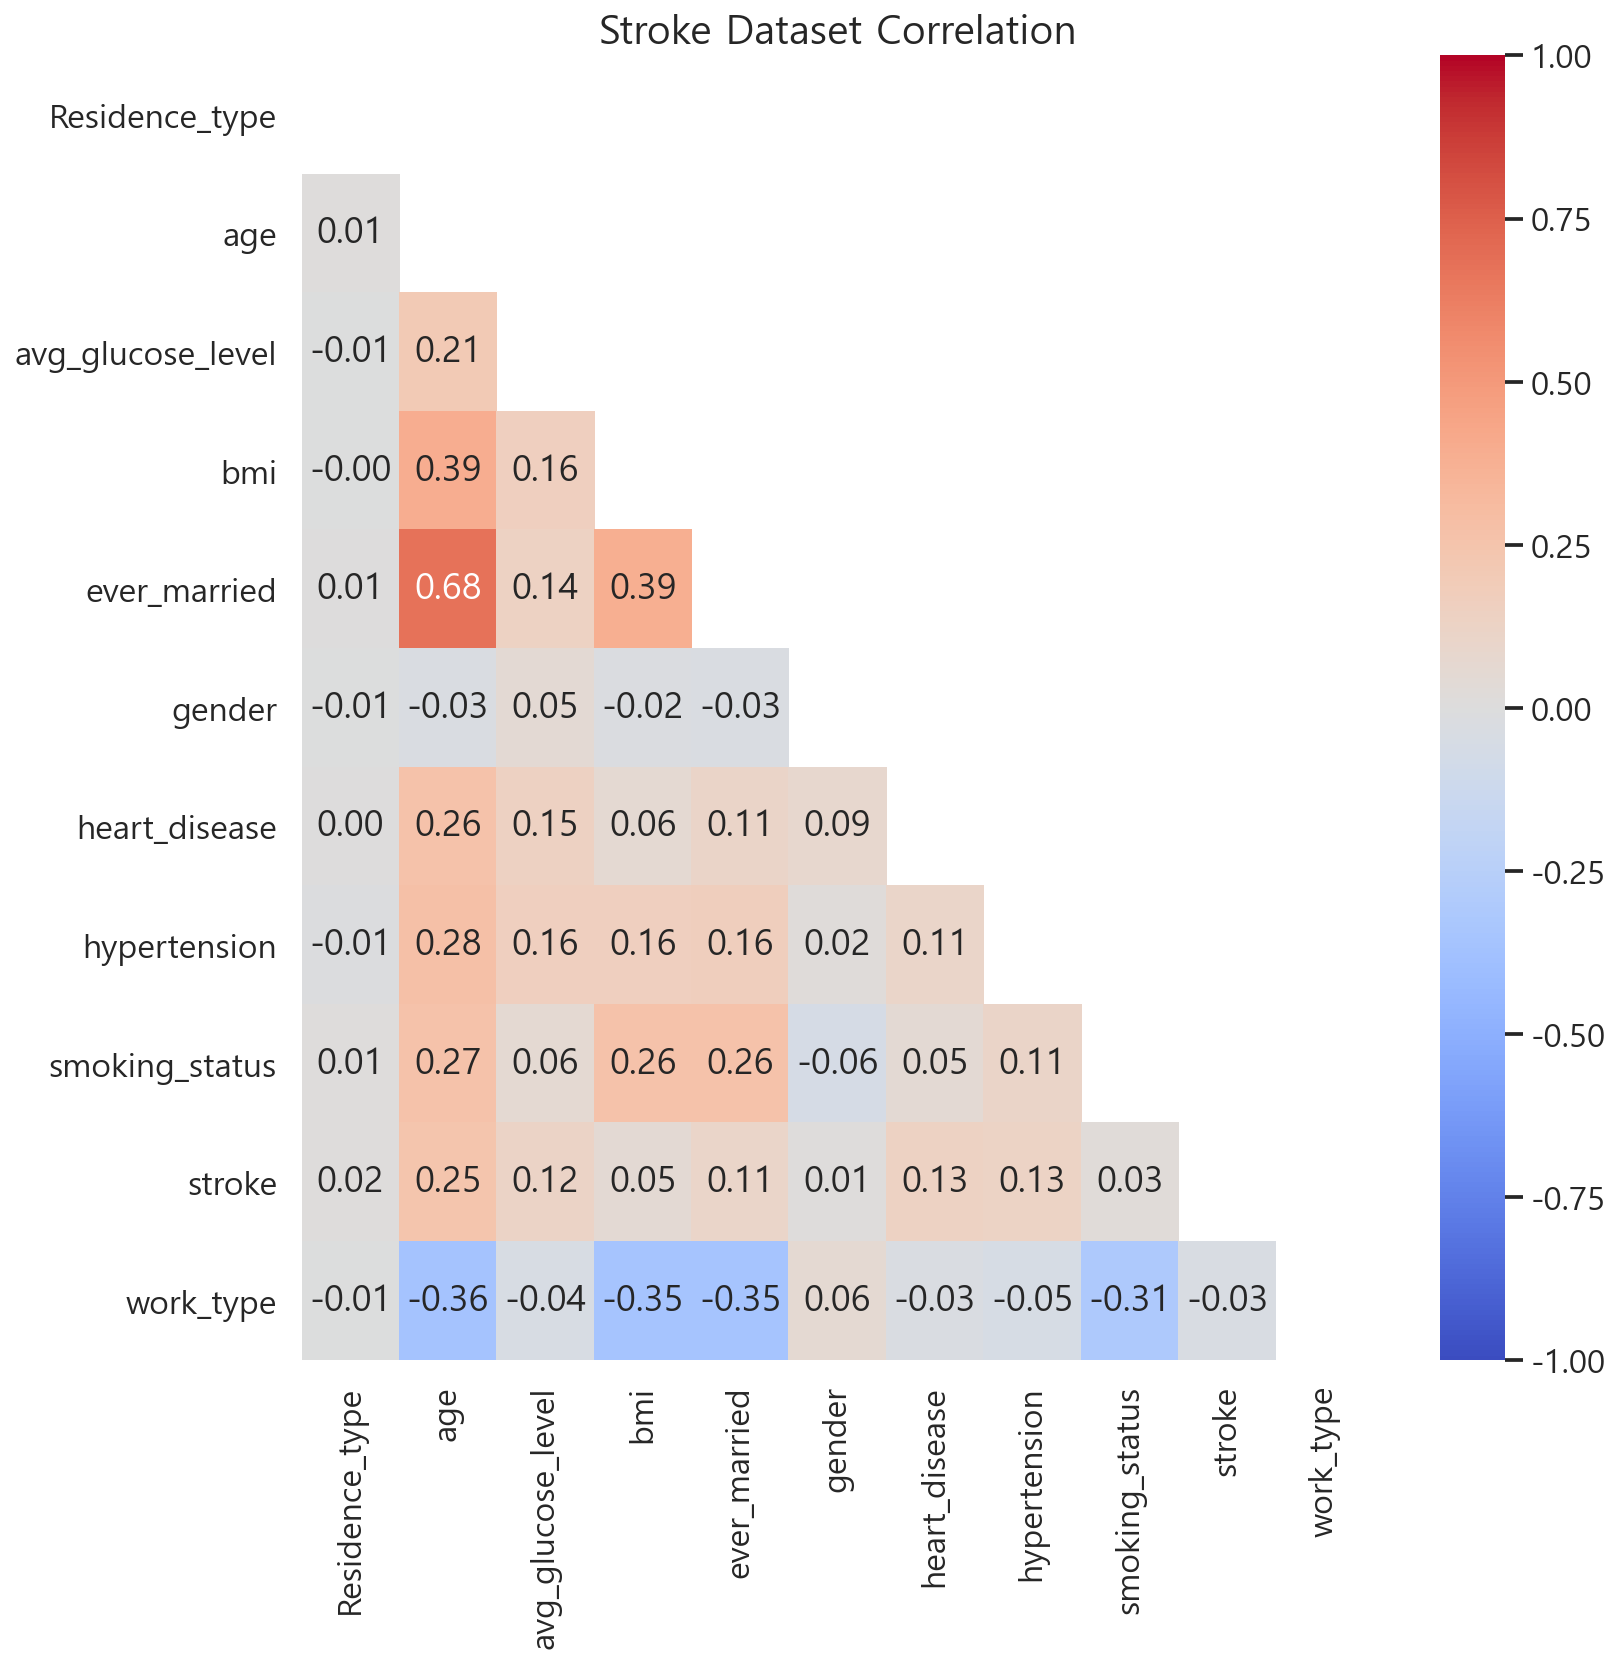

In [22]:
corr_plot(df, 'coolwarm',12, 12, 'Stroke Dataset Correlation')

In [23]:
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('stroke',axis=1))
print('X_scaled.shape :',X_scaled.shape)

X_scaled.shape : (5109, 10)


## 4. ML Model Train

In [24]:
print('df.shape :',df.shape)
df.head()

df.shape : (5109, 11)


,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
0,1,67.0,5.436731,3.627004,1,1,1,0,1,1,2
1,0,61.0,5.314240,3.397677,1,0,0,0,2,1,3
2,0,80.0,4.672081,3.511545,1,1,1,0,2,1,2
3,1,49.0,5.148831,3.566712,1,0,0,0,3,1,2
4,0,79.0,5.165471,3.218876,1,0,0,1,2,1,3


### 데이터 분할

In [25]:
X_data = X_scaled
y_data = df['stroke']
print('X_data.shape :',X_data.shape)
print('y_data.shape :',y_data.shape,'\n')

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify = y_data,
                                                   shuffle=True, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_test.shape)
print('y_Test.shape :',y_test.shape)

X_data.shape : (5109, 10)
y_data.shape : (5109,) 

X_train.shape : (4087, 10)
y_train.shape : (4087,)
X_test.shape : (1022, 10)
y_Test.shape : (1022,)


### 데이터 오버샘플링

In [26]:
sm = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print('X_smote.shape :',X_smote.shape)
print('y_smote.shape :',y_smote.shape)

X_smote.shape : (7776, 10)
y_smote.shape : (7776,)


In [27]:
y_smote.value_counts()

0    3888
1    3888
Name: stroke, dtype: int64

### 데이터 재분할

In [45]:
total = pd.concat([pd.DataFrame(X_smote), y_smote], axis=1)

target_0 = total[total['stroke'] == 0] 
target_1 = total[total['stroke'] == 1] 

print(target_0.shape, target_1.shape)
half = round(len(total[total['stroke'] == 1]) / 2)
half

(3888, 11) (3888, 11)


1944

In [49]:
target_1 = target_1.sample(half, random_state=42)
df = pd.concat([target_0, target_1], axis=0).reset_index(drop=True)
df['stroke'].value_counts()

0    3888
1    1944
Name: stroke, dtype: int64

In [69]:
X_smote = df.drop('stroke',axis=1).to_numpy()
y_smote = df['stroke']
print(X_smote.shape, y_smote.shape)

(5832, 10) (5832,)


### Model Training

In [87]:
LGBM_clf = LGBMClassifier(learning_rate=0.3, max_depth=4, random_state=25)
XGB_clf = XGBClassifier(learning_rate=0.3, max_depth=4, random_state=25)
evals = [(X_smote, y_smote)]

XGB_clf.fit(X_smote, y_smote, eval_metric='logloss' )
LGBM_clf.fit(X_smote, y_smote, eval_metric='log_loss')

LGBMClassifier(learning_rate=0.3, max_depth=4, random_state=25)

In [88]:
# train data Evalutation
XGB_pred_train = XGB_clf.predict(X_smote)
print('XGB_pred_train ACC :',np.round(accuracy_score(y_smote,XGB_pred_train),4),'\n')
get_clf_eval(y_smote,XGB_pred_train)

XGB_pred_train ACC : 0.9854 

[[3883    5]
 [  80 1864]]
정확도 :0.9854, 정밀도 :0.9973, 재현율 :0.9588, F1 :0.9777


In [89]:
# test data Evalutation
XGB_pred_test = XGB_clf.predict(X_test)
print('XGB_pred_test ACC :',np.round(accuracy_score(y_test,XGB_pred_test),4),'\n')
get_clf_eval(y_test,XGB_pred_test)

XGB_pred_test ACC : 0.9491 

[[967   5]
 [ 47   3]]
정확도 :0.9491, 정밀도 :0.3750, 재현율 :0.0600, F1 :0.1034


In [99]:
# train data Evalutation
LGBM_pred_train = LGBM_clf.predict(X_smote)
print('LGBM_pred_train ACC :',np.round(accuracy_score(y_smote,LGBM_pred_train),4),'\n')
get_clf_eval(y_smote,LGBM_pred_train)

LGBM_pred_train ACC : 0.987 

[[3884    4]
 [  72 1872]]
정확도 :0.9870, 정밀도 :0.9979, 재현율 :0.9630, F1 :0.9801


In [100]:
# test data Evalutation
LGBM_pred_test = LGBM_clf.predict(X_test)
print('LGBM_pred_test ACC :',np.round(accuracy_score(y_test,LGBM_pred_test),4),'\n')
get_clf_eval(y_test,LGBM_pred_test)

LGBM_pred_test ACC : 0.9452 

[[964   8]
 [ 48   2]]
정확도 :0.9452, 정밀도 :0.2000, 재현율 :0.0400, F1 :0.0667


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

## 6. Precision & Recall TradeOff

In [93]:
best_train_proba = XGB_clf.predict_proba(X_smote)
best_train_proba_1 = best_train_proba[:,1]

best_test_proba = XGB_clf.predict_proba(X_test)
best_test_proba_1 = best_test_proba[:,1]

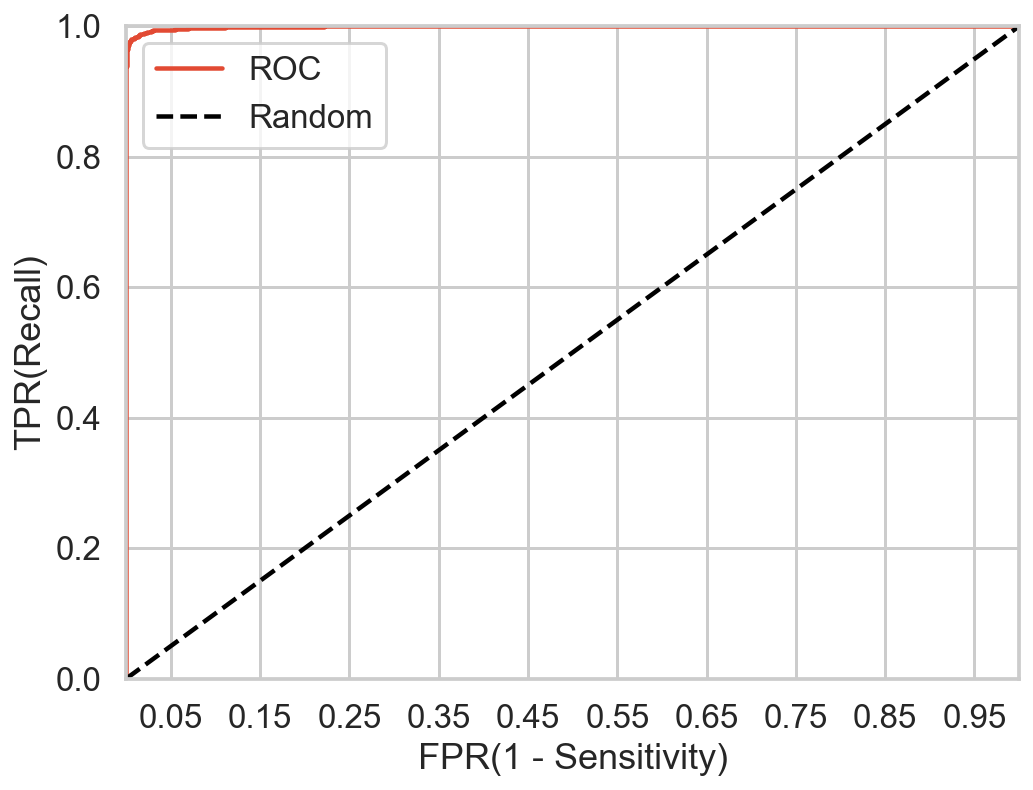

In [94]:
roc_curve_plot(y_smote, best_train_proba_1)

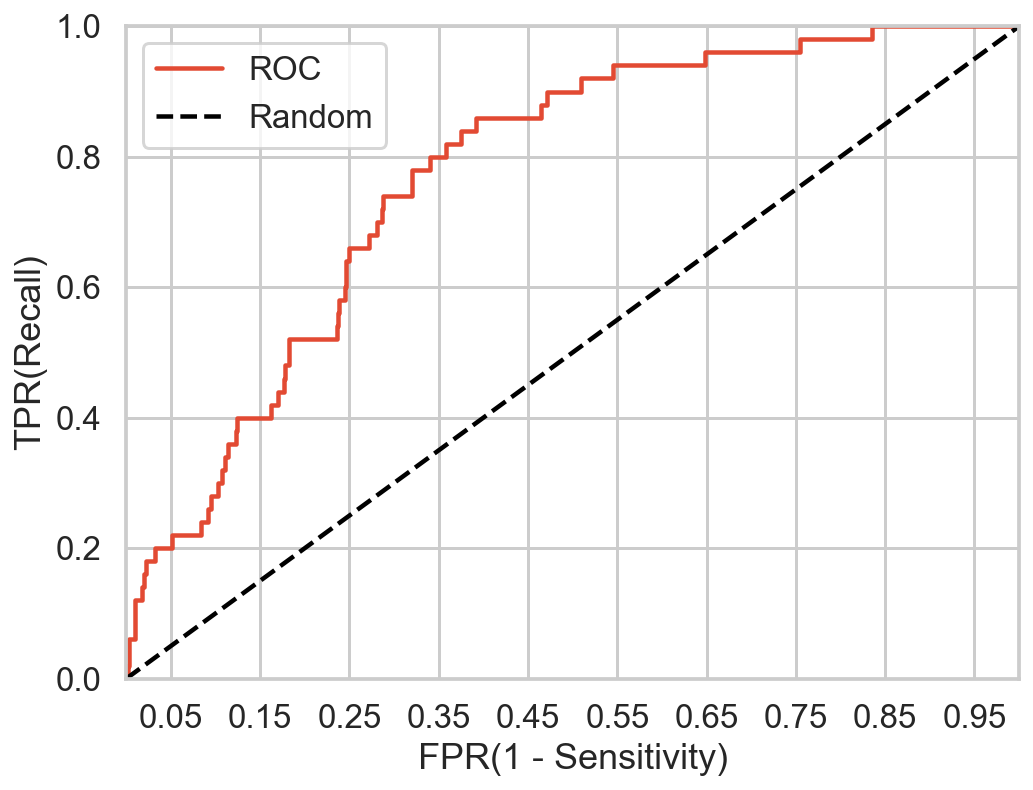

In [95]:
roc_curve_plot(y_test, best_test_proba_1)

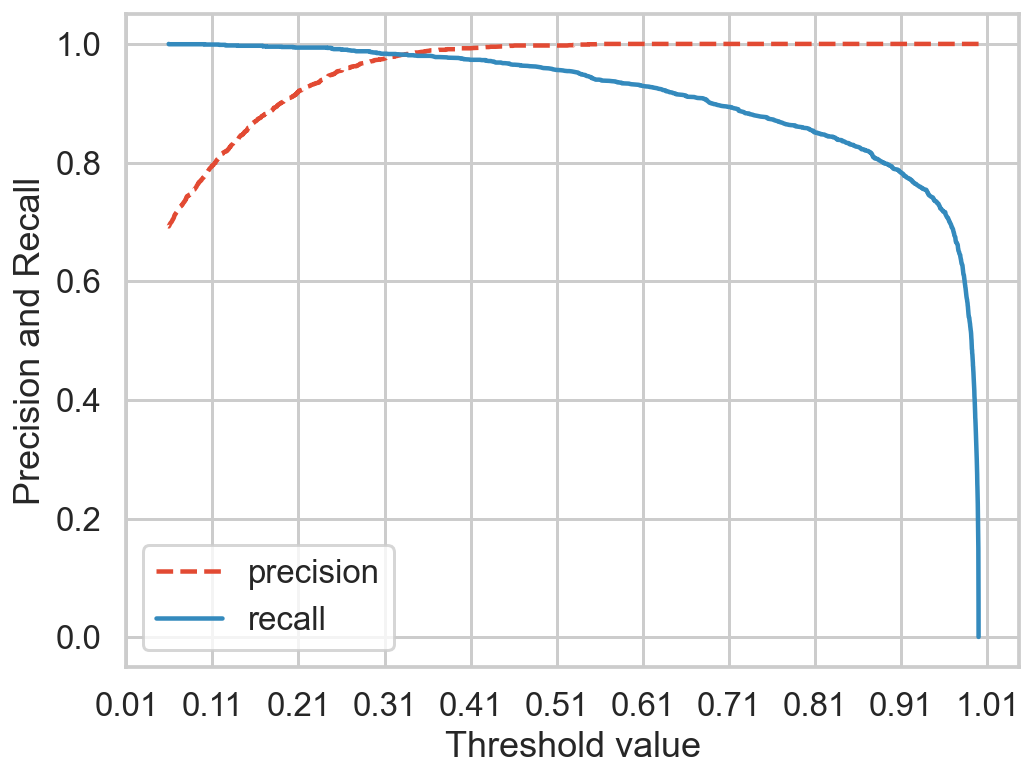

In [96]:
precision_recall_curve_plot(y_smote,best_train_proba_1)

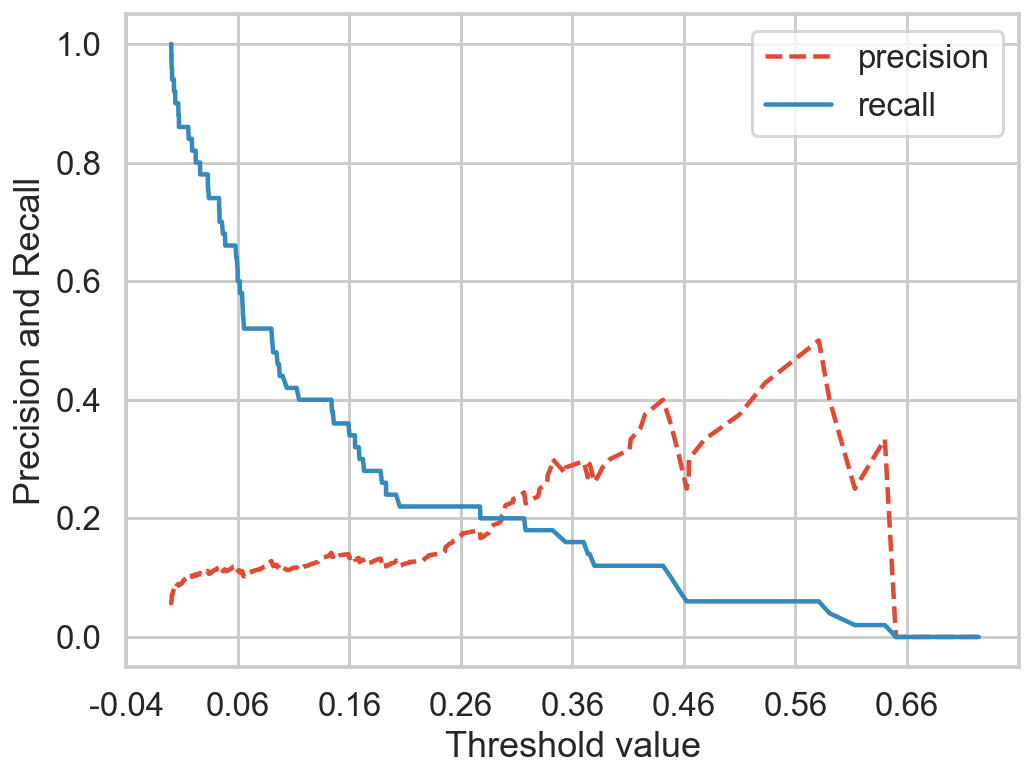

In [97]:
precision_recall_curve_plot(y_test,best_test_proba_1)

## 7. 사후 튜닝

In [88]:
after_pred = (best_test_proba[:,1] > 0.27)*1
after_pred

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
get_clf_eval(y_test,after_pred)

[[855 117]
 [ 32  18]]
정확도 :0.8542, 정밀도 :0.1333, 재현율 :0.3600, F1 :0.1946


In [90]:
after_pred = (best_test_proba[:,1] > 0.07)*1
after_pred

array([0, 0, 1, ..., 0, 0, 0])

In [91]:
get_clf_eval(y_test,after_pred)

[[643 329]
 [ 13  37]]
정확도 :0.6654, 정밀도 :0.1011, 재현율 :0.7400, F1 :0.1779


## 8. 모델 분석

In [92]:
# 피처의 중요도를 추출하기
best_est.feature_importances_

array([0.08989709, 0.19391939, 0.03277478, 0.04295967, 0.06490453,
       0.08356676, 0.06628781, 0.04623672, 0.19730663, 0.18214661],
      dtype=float32)

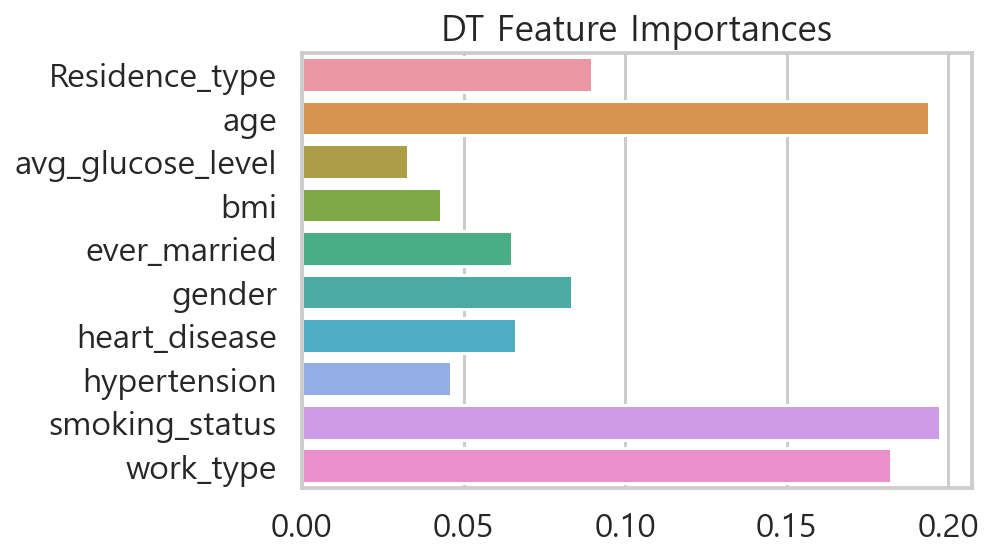

In [94]:
# 피처의 중요도 시각화 하기
plt.title('DT Feature Importances')
sns.barplot(x = best_est.feature_importances_, y = df.columns.difference(['stroke']))
plt.show()